In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError  
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# 1. 저장된 모델, 임계치, 인코더더 불러오기
loaded_model = load_model('./LSTM_결과/임계치_0.4864.h5', custom_objects={'mae': MeanSquaredError()})

# 임계치 불러오기
with open('./LSTM_결과/임계치_0.4864.pkl', 'rb') as f:
    threshold = pickle.load(f)

# LabelEncoder 불러오기
with open('./LSTM_결과/event_type_encoder.pkl', 'rb') as f:
    le_event = pickle.load(f)

with open('./LSTM_결과/hub_type_encoder.pkl', 'rb') as f:
    le_hub = pickle.load(f)

# MinMaxScaler 불러오기
with open('./LSTM_결과/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# 새로운 Label 처리
def safe_transform(le, values):
    # LabelEncoder에 없는 새로운 값 찾기
    unknown_values = set(values) - set(le.classes_)
    
    # 새로운 값이 있으면 LabelEncoder 클래스에 추가
    if unknown_values:
        print(f"Warning: 새로운 값 발견 {unknown_values}. 새로운 라벨로 추가합니다.")
        le.classes_ = np.append(le.classes_, list(unknown_values))
    else:
        print("새로운 값이 없습니다. 기존 클래스만 변환합니다.")

    return le.transform(values)

print("불러온 임계치:", threshold)

불러온 임계치: 0.4864602896079038


In [75]:
# 2. 테스트 데이터 불러오기  
df_normal_test = pd.read_csv("./Data/정상데이터2.csv")
df_anomaly_test = pd.read_csv("./Data/이상데이터2.csv")

# 각 데이터에 레이블 추가: 정상 0, 이상 1
df_normal_test['label'] = 0
df_anomaly_test['label'] = 1

# 두 데이터를 합침
df_test = pd.concat([df_normal_test, df_anomaly_test], ignore_index=True)

In [76]:
# 3. 테스트 데이터 전처리  
# (학습 시 사용한 전처리와 동일하게 처리해야 함)
df_test['event_time'] = pd.to_datetime(df_test['event_time'])
df_test = df_test.sort_values(by=['epc_code', 'product_serial', 'event_time'])

# 각 제품 그룹별 첫 이벤트 기준으로 시간 차이(time_delta) 계산
df_test['time_delta'] = df_test.groupby(['epc_code', 'product_serial'])['event_time'] \
                               .transform(lambda x: (x - x.min()).dt.total_seconds())

# 범주형 변수 인코딩
df_test['event_type_enc'] = safe_transform(le_event, df_test['event_type'])
df_test['hub_type_enc'] = safe_transform(le_hub, df_test['hub_type'])

# 수치형 변수 정규화
df_test['time_delta_scaled'] = scaler.transform(df_test[['time_delta']])

새로운 값이 없습니다. 기존 클래스만 변환합니다.


In [77]:
print("전처리 후 데이터 샘플:")
display(df_test[['epc_code', 'product_serial', 'event_time', 'time_delta', 
          'event_type', 'event_type_enc', 'hub_type', 'hub_type_enc', 'time_delta_scaled']].head(10))

전처리 후 데이터 샘플:


,epc_code,product_serial,event_time,time_delta,event_type,event_type_enc,hub_type,hub_type_enc,time_delta_scaled
200,001.8805843.584374.000000003,3,2025-01-21 17:54:00,0.0,commissioning,3,Yeongju,5,0.000000
201,001.8805843.584374.000000003,3,2025-01-21 18:15:00,1260.0,aggregation,2,Yeongju,5,0.000105
202,001.8805843.584374.000000003,3,2025-01-21 19:11:00,4620.0,WMS_inbound,0,Yeongju,5,0.000384
203,001.8805843.584374.000000003,3,2025-02-02 20:43:00,1046940.0,WMS_outbound,1,Yeongju,5,0.087077
204,001.8805843.584374.000000003,3,2025-02-03 01:23:00,1063740.0,illegal_transfer,10,Busan,0,0.088474
205,001.8805843.584374.000000003,3,2025-03-07 02:46:00,3833520.0,stock_outbound(HUB),7,Busan,0,0.318843
206,001.8805843.584374.000000003,3,2025-03-07 06:22:00,3846480.0,stock_inbound(Wholesaler),6,Busan,0,0.319921
207,001.8805843.584374.000000003,3,2025-04-07 00:04:00,6502200.0,stock_outbound(Wholesaler),9,Busan,0,0.540804
208,001.8805843.584374.000000003,3,2025-04-07 02:29:00,6510900.0,stock_inbound(Reseller),5,Busan,0,0.541527
209,001.8805843.584374.000000003,3,2025-04-21 05:36:00,7731720.0,stock_outbound(Sell),8,Busan,0,0.643066


In [78]:
# 4. 시퀀스 데이터 구성 함수 (학습 시와 동일)
max_seq_length = 10  # 학습 시 사용한 시퀀스 길이와 동일하게
feature_columns = ['event_type_enc', 'hub_type_enc', 'time_delta_scaled']

def create_sequence(group, max_seq_length, feature_columns):
    seq = group[feature_columns].values  # shape: (num_events, num_features)
    if len(seq) < max_seq_length:
        padding = np.zeros((max_seq_length - len(seq), len(feature_columns)))
        seq = np.vstack([seq, padding])
    else:
        seq = seq[:max_seq_length]
    return seq

# 그룹핑: epc_code와 product_serial 별로 시퀀스 구성
grouped_test = df_test.groupby(['epc_code', 'product_serial'])
sequences_test = grouped_test.apply(lambda x: create_sequence(x, max_seq_length, feature_columns))

# sequences_test는 pandas Series이므로 numpy array로 변환
X_test = np.stack(sequences_test.values)
print("테스트 시퀀스 데이터 shape:", X_test.shape)  # (그룹 수, max_seq_length, feature 수)

테스트 시퀀스 데이터 shape: (42, 10, 3)


C:\Users\ysjgo\AppData\Local\Temp\ipykernel_20564\209135755.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequences_test = grouped_test.apply(lambda x: create_sequence(x, max_seq_length, feature_columns))


In [79]:
# 5. 테스트 데이터 예측 및 재구성 오차 계산
X_pred_test = loaded_model.predict(X_test)
reconstruction_errors_test = np.mean(np.square(X_pred_test - X_test), axis=(1,2))

# 저장된 임계치(threshold)보다 오차가 큰 시퀀스는 이상으로 판정
predicted_anomalies = reconstruction_errors_test > threshold

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [80]:
# 6. 그룹별 실제 레이블 결정  
# 한 그룹 내에 하나라도 이상 이벤트(label==1)가 있으면 해당 시퀀스를 이상으로 간주합니다.
group_labels = grouped_test['label'].max()  # 그룹별 max 값 (0 또는 1)
group_labels = group_labels.sort_index()  # 시퀀스 데이터 순서와 동일하게 정렬

테스트 데이터 그룹(시퀀스) 총 개수: 42
모델이 이상으로 판정한 그룹 수: 20
Confusion Matrix:



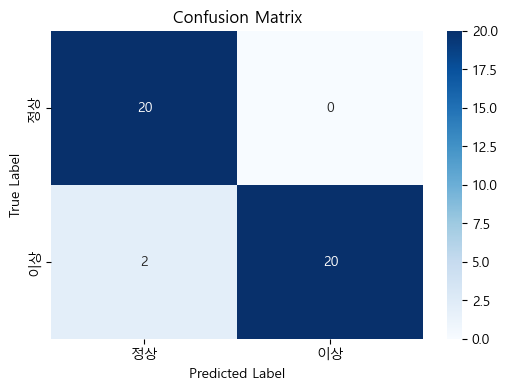

Metrics DataFrame:
     precision(정밀도)  recall(재현율)  f1-score(점수)
정상        0.909091     1.000000      0.952381
이상        1.000000     0.909091      0.952381


In [81]:
# 7. 결과 평가
num_sequences = len(X_test)
num_detected = predicted_anomalies.sum()

print(f"테스트 데이터 그룹(시퀀스) 총 개수: {num_sequences}")
print(f"모델이 이상으로 판정한 그룹 수: {num_detected}")

# 혼동 행렬 및 분류 리포트 출력 및 시각화화
cm = confusion_matrix(group_labels, predicted_anomalies)

labels = ["정상", "이상"]

# 한글 폰트 경로 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

print("Confusion Matrix:\n")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. 분류 리포트 출력
report_dict = classification_report(group_labels, predicted_anomalies, target_names=["정상", "이상"], output_dict=True)

# pandas DataFrame으로 변환
report_df = pd.DataFrame(report_dict).transpose()

metrics_df = report_df.loc[['정상', '이상']][['precision', 'recall', 'f1-score']]

metrics_df.columns = ['precision(정밀도)', 'recall(재현율)', 'f1-score(점수)']
print("Metrics DataFrame:\n", metrics_df)